# GCN

In [1]:

import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

We use the dataset cleaned by below

In [2]:
! git clone https://github.com/HKUDS/LightGCL.git
%cd /kaggle/working/LightGCL

Cloning into 'LightGCL'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 157 (delta 18), reused 10 (delta 10), pack-reused 135 (from 1)
Receiving objects: 100% (157/157), 52.42 MiB | 39.47 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/kaggle/working/LightGCL


In [3]:
train_data_path = "/kaggle/working/LightGCL/data/yelp/trnMat.pkl"
test_data_path  = "/kaggle/working/LightGCL/data/yelp/tstMat.pkl"

train_matrix = pd.read_pickle(train_data_path)  # coo_matrix
test_matrix = pd.read_pickle(test_data_path)    # coo_matrix

n_users = train_matrix.shape[0]
n_items = train_matrix.shape[1]
print("Number of users:", n_users)
print("Number of items:", n_items)

Number of users: 29601
Number of items: 24734


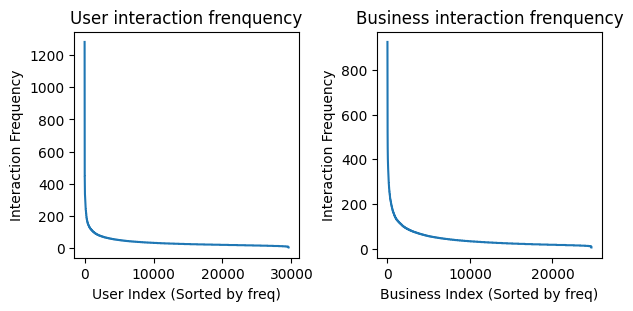

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)


user_sums = np.array(train_matrix.sum(axis=1)).flatten()
user_freq = sorted(user_sums, reverse = True)
# Visulize Via Bar Chart
axes[0].plot(user_freq)
axes[0].set_title("User interaction frenquency")
axes[0].set_xlabel("User Index (Sorted by freq)")
axes[0].set_ylabel("Interaction Frequency")

col_sums = np.array(train_matrix.sum(axis=0)).flatten()
col_freq = sorted(col_sums, reverse = True)
# Visulize Via Bar Chart
axes[1].plot(col_freq)
axes[1].set_title("Business interaction frenquency")
axes[1].set_xlabel("Business Index (Sorted by freq)")
axes[1].set_ylabel("Interaction Frequency")

plt.show()


In [5]:
def build_adjacency_matrix(train_mat):
    """
     A = [[0, R],
         [R^T, 0]]
    """
    n_users = train_mat.shape[0]
    n_items = train_mat.shape[1]
    
    user_indices = train_mat.row
    item_indices = train_mat.col
    data = train_mat.data  
    
    item_indices_offset = item_indices + n_users
    
    adj_row = np.concatenate([user_indices, item_indices_offset])
    adj_col = np.concatenate([item_indices_offset, user_indices])
    adj_data = np.concatenate([data, data])
    
    adj_mat = coo_matrix((adj_data, (adj_row, adj_col)), 
                         shape=(n_users + n_items, n_users + n_items))
    return adj_mat.tocsr()

adj_matrix = build_adjacency_matrix(train_matrix)


In [6]:
# user positive items
user_pos_items = {}
train_coo = train_matrix.tocoo()
for u, i in zip(train_coo.row, train_coo.col):
    if u not in user_pos_items:
        user_pos_items[u] = set()
    user_pos_items[u].add(i)

In [7]:
import torch
import torch.nn as nn
import numpy as np
from scipy.sparse import coo_matrix

class GCN(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim, n_layers, adj_mat, dropout=0.5, activation=nn.ReLU()):
        super(GCN, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.activation = activation
        
        self.n_nodes = n_users + n_items
        
        self.embedding = nn.Embedding(self.n_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        
        self.weight_layers = nn.ModuleList([nn.Linear(embedding_dim, embedding_dim, bias=True) for _ in range(n_layers)])
        
        self.norm_adj = self._get_norm_adj_mat(adj_mat)
        
    def _get_norm_adj_mat(self, adj_mat):
        """
         D^-1/2 * A * D^-1/2  
        """
        rowsum = np.array(adj_mat.sum(axis=1)).reshape(-1)
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        
        d_inv_sqrt_mat = coo_matrix(
            (d_inv_sqrt, (np.arange(len(d_inv_sqrt)), np.arange(len(d_inv_sqrt)))),
            shape=(len(d_inv_sqrt), len(d_inv_sqrt))
        ).tocsr()
        
        norm_adj_mat = d_inv_sqrt_mat.dot(adj_mat).dot(d_inv_sqrt_mat)
        return self._convert_sp_mat_to_sp_tensor(norm_adj_mat)
    
    @staticmethod
    def _convert_sp_mat_to_sp_tensor(sp_mat):
        coo = sp_mat.tocoo().astype(np.float32)
        indices = torch.LongTensor([coo.row, coo.col])
        values = torch.FloatTensor(coo.data)
        shape = torch.Size(coo.shape)
        return torch.sparse.FloatTensor(indices, values, shape)
    
    def forward(self):
        """
        E = E^(L)
        E^(l) = activation(norm_adj * E^(l-1) * W^(l))  for l = 1, ..., L
        """
        all_embeddings = self.embedding.weight  # E^(0)
        
        g_droped = self.norm_adj.to(all_embeddings.device)
        
        for layer in range(self.n_layers):
            all_embeddings = torch.sparse.mm(g_droped, all_embeddings)
            # linear transformation
            all_embeddings = self.weight_layers[layer](all_embeddings)
            all_embeddings = self.activation(all_embeddings)
            # Dropout
            all_embeddings = nn.functional.dropout(all_embeddings, p=self.dropout, training=self.training)
        
        return all_embeddings

    
    def get_user_item_emb(self):
        """
        Return user or item embedding
        """
        final_emb = self.forward()
        user_emb = final_emb[:self.n_users]
        item_emb = final_emb[self.n_users:]
        return user_emb, item_emb


In [8]:
class BPRData(Dataset):
    def __init__(self, user_pos_dict, n_items, num_neg=1):
        super(BPRData, self).__init__()
        self.user_pos_dict = user_pos_dict  # user -> set(pos_items)
        self.users = list(user_pos_dict.keys())
        self.n_items = n_items
        self.num_neg = num_neg
        
        # Construct all positive pairs
        self.pos_pairs = []
        for u, pos_items in user_pos_dict.items():
            for i in pos_items:
                self.pos_pairs.append((u, i))
    
    def __len__(self):
        return len(self.pos_pairs)
    
    def __getitem__(self, idx):
        u, i = self.pos_pairs[idx]
        # Negative samples
        while True:
            j = np.random.randint(0, self.n_items)
            if j not in self.user_pos_dict[u]:
                break
        return u, i, j


In [9]:
def bpr_loss(user_emb, item_emb_pos, item_emb_neg):
    """
    BPR Loss
    L = - sum( log( sigma( (u·i_pos) - (u·i_neg) ) ) )
    """
    # (batch, dim) -> (batch)
    score_pos = torch.sum(user_emb * item_emb_pos, dim=1)
    score_neg = torch.sum(user_emb * item_emb_neg, dim=1)
    diff = score_pos - score_neg
    return -torch.mean(torch.log(torch.sigmoid(diff) + 1e-8))


In [10]:
def train_gcn(model, user_pos_items, n_items, reg=1e-4, 
                   epochs=10, batch_size=1024, lr=1e-3, device='cpu'):
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    bpr_dataset = BPRData(user_pos_items, n_items)
    bpr_dataloader = DataLoader(bpr_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        
        for batch_data in bpr_dataloader:
            user, pos, neg = batch_data
            user = user.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            
            user_emb, item_emb = model.get_user_item_emb()
            
            # embedding
            u_e = user_emb[user]
            i_e = item_emb[pos]
            j_e = item_emb[neg]
            
            # BPR Loss
            loss_bpr = bpr_loss(u_e, i_e, j_e)
            
            # L2 Reg
            reg_loss = reg * (u_e.norm(2).pow(2) + i_e.norm(2).pow(2) + j_e.norm(2).pow(2)) / float(len(user))
            loss = loss_bpr + reg_loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"[GCN] Epoch={epoch}, Loss={total_loss:.4f}")
    
    return model


In [11]:
def evaluate_model(model, train_matrix, test_matrix, k=20, device='cpu'):
    """
    Calculate Recall@k, NDCG@k
    """
    model.eval()
    user_emb, item_emb = model.get_user_item_emb()
    user_emb = user_emb.to(device)
    item_emb = item_emb.to(device)
    
    scores = torch.matmul(user_emb, item_emb.t())  # (n_users, n_items)
    
    # Exclude the interacted item in test set
    train_coo = train_matrix.tocoo()
    for u, i in zip(train_coo.row, train_coo.col):
        scores[u, i] = -1e9  # exclude
    
    # top-K
    _, topk_indices = torch.topk(scores, k=k, dim=1)  # (n_users, k)
    
    # evual
    test_coo = test_matrix.tocoo()
    test_dict = {}
    for u, i in zip(test_coo.row, test_coo.col):
        if u not in test_dict:
            test_dict[u] = []
        test_dict[u].append(i)
    
    recall, ndcg, n_users_test = 0.0, 0.0, 0
    
    for user in test_dict:
        true_items = set(test_dict[user])
        pred_items = topk_indices[user].cpu().numpy().tolist()
        
        hit = 0
        ndcg_score = 0.0
        for rank, item in enumerate(pred_items):
            if item in true_items:
                hit += 1
                ndcg_score += 1.0 / np.log2(rank+2)
        
        recall_u = hit / len(true_items)
        ndcg_u = ndcg_score / sum(1.0/np.log2(r+2) for r in range(len(true_items)))
        
        recall += recall_u
        ndcg += ndcg_u
        n_users_test += 1
    
    return recall / n_users_test, ndcg / n_users_test


In [12]:
def long_tail_evaluate(model, train_matrix, test_matrix, k=20, n_groups=10, device='cpu'):
    """
    Compute Recall@K for items grouped by popularity.    
    """
    # count interaction times
    item_counts = np.array(train_matrix.sum(axis=0)).flatten()  # shape (n_items,)
    n_items = len(item_counts)
    
    # sorted by popularity
    sorted_items = np.argsort(item_counts)  
    group_size = n_items // n_groups
    item_groups = []
    for g in range(n_groups):
        start = g * group_size
        end = (g + 1) * group_size if g < n_groups - 1 else n_items
        item_groups.append(set(sorted_items[start:end]))
    
    # Get the embedding
    model.eval()
    user_emb, item_emb = model.get_user_item_emb()
    user_emb = user_emb.to(device)
    item_emb = item_emb.to(device)
    
    # get the scores
    scores = torch.matmul(user_emb, item_emb.t())  # (n_users, n_items)
    
    # exclude the interacted items
    train_coo = train_matrix.tocoo()
    for u, i in zip(train_coo.row, train_coo.col):
        scores[u, i] = -1e9  
    
    # Get top-k
    _, topk_indices = torch.topk(scores, k=k, dim=1)  # (n_users, k)
    
    # Get the user interaction in test set
    test_coo = test_matrix.tocoo()
    test_dict = {}
    for u, i in zip(test_coo.row, test_coo.col):
        if u not in test_dict:
            test_dict[u] = []
        test_dict[u].append(i)
    
    # Initialize Recall@K
    recall_per_group = [0.0] * n_groups
    group_counts = [0] * n_groups  
    
    for user in test_dict:
        true_items = set(test_dict[user]) 
        pred_items = topk_indices[user].cpu().numpy().tolist()
        
        for g in range(n_groups):
            group_items = item_groups[g]
            true_in_group = true_items & group_items  
            if len(true_in_group) == 0:
                continue
            
            pred_in_group = set(pred_items) & group_items  
            hit = len(pred_in_group & true_in_group)
            
            recall_per_group[g] += hit / len(true_in_group)
            group_counts[g] += 1
    
    for g in range(n_groups):
        if group_counts[g] > 0:
            recall_per_group[g] /= group_counts[g]
    
    return recall_per_group


In [21]:
def t_SNE_long_tail_visu(lightgcn_model, model_type):
    adj_matrix = build_adjacency_matrix(train_matrix)
    
    n_users = train_matrix.shape[0]
    n_items = train_matrix.shape[1]
    
    lightgcn_model.eval() 
    with torch.no_grad():
        user_emb, item_emb = lightgcn_model.get_user_item_emb()  
    item_embeddings = item_emb.cpu().numpy() 
    
    # Get the head and tail nodes (10% as tail)
    item_interaction_counts = np.array(train_matrix.sum(axis=0)).flatten()
    threshold = np.percentile(item_interaction_counts, 95)  
    
    long_tail_items = np.where(item_interaction_counts <= threshold)[0]
    popular_items = np.where(item_interaction_counts > threshold)[0]
    
    # Get 1000 samples from tail and head nodes
    num_samples = 1000
    sampled_long_tail_items = random.sample(list(long_tail_items), min(len(long_tail_items), num_samples))
    sampled_popular_items = random.sample(list(popular_items), min(len(popular_items), num_samples))
    
    
    sampled_items = np.array(sampled_long_tail_items + sampled_popular_items)
    sampled_embeddings = item_embeddings[sampled_items]

    # t-SNE 
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    sampled_2d_embeddings = tsne.fit_transform(sampled_embeddings)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(
        sampled_2d_embeddings[:len(sampled_long_tail_items), 0],
        sampled_2d_embeddings[:len(sampled_long_tail_items), 1],
        label='Long-tail Items', alpha=0.7, c='blue'
    )
    plt.scatter(
        sampled_2d_embeddings[len(sampled_long_tail_items):, 0],
        sampled_2d_embeddings[len(sampled_long_tail_items):, 1],
        label='Popular Items', alpha=0.7, c='orange'
    )
    plt.title(model_type + ' Item Embedding Visualization (t-SNE, Sampled)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

In [14]:
def bar_plot(num_group, model_name):
    groups = [f"Group {i}" for i in range(1, num_group+1)]
    plt.figure(figsize=(10, 6))
    plt.bar(groups, recall_per_group, alpha=0.8)
    plt.title(model_name + " Recall@20 by Group", fontsize=14)
    plt.xlabel("Groups", fontsize=12)
    plt.ylabel("Recall@20", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model_gcn = GCN(n_users=n_users, n_items=n_items, embedding_dim=64, n_layers=2, adj_mat=adj_matrix, dropout=0.2, activation=nn.ReLU())
model_gcn.to(device)

<ipython-input-7-9b0ebd5e07f0>:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  indices = torch.LongTensor([coo.row, coo.col])
<ipython-input-7-9b0ebd5e07f0>:47: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(indices, values, shape)


GCN(
  (activation): ReLU()
  (embedding): Embedding(54335, 64)
  (weight_layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
)

In [16]:
# Train the GCN model
trained_model = train_gcn(
    model=model_gcn,
    user_pos_items=user_pos_items,
    n_items=n_items,
    reg=1e-4,
    epochs=100,
    batch_size=1024,
    lr=1e-3,
    device='cuda'  
)

# Get the recall
recall, ndcg = evaluate_model(model_gcn, train_matrix, test_matrix, k=20, device=device)
print(f"GCN Overall  Recall@20={recall:.4f}  NDCG@20={ndcg:.4f}")

recall_per_group = long_tail_evaluate(
    model=model_gcn,
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    k=20,
    n_groups=10,
    device='cuda'
)

for g, recall in enumerate(recall_per_group):
    print(f"Group {g+1}: Recall@20 = {recall:.4f}")

[GCN] Epoch=0, Loss=395.9973
[GCN] Epoch=1, Loss=285.2369
[GCN] Epoch=2, Loss=250.6292
[GCN] Epoch=3, Loss=208.5738
[GCN] Epoch=4, Loss=201.4534
[GCN] Epoch=5, Loss=195.6644
[GCN] Epoch=6, Loss=190.8155
[GCN] Epoch=7, Loss=188.1268
[GCN] Epoch=8, Loss=185.5181
[GCN] Epoch=9, Loss=183.2289
[GCN] Epoch=10, Loss=181.4713
[GCN] Epoch=11, Loss=179.5132
[GCN] Epoch=12, Loss=178.7979
[GCN] Epoch=13, Loss=176.7606
[GCN] Epoch=14, Loss=175.7048
[GCN] Epoch=15, Loss=175.4456
[GCN] Epoch=16, Loss=173.4797
[GCN] Epoch=17, Loss=172.1908
[GCN] Epoch=18, Loss=171.3044
[GCN] Epoch=19, Loss=170.1687
[GCN] Epoch=20, Loss=170.1527
[GCN] Epoch=21, Loss=167.9755
[GCN] Epoch=22, Loss=167.4076
[GCN] Epoch=23, Loss=165.8100
[GCN] Epoch=24, Loss=166.4984
[GCN] Epoch=25, Loss=165.4267
[GCN] Epoch=26, Loss=165.2977
[GCN] Epoch=27, Loss=164.2988
[GCN] Epoch=28, Loss=164.9510
[GCN] Epoch=29, Loss=164.3378
[GCN] Epoch=30, Loss=164.5328
[GCN] Epoch=31, Loss=164.1937
[GCN] Epoch=32, Loss=162.4818
[GCN] Epoch=33, Loss

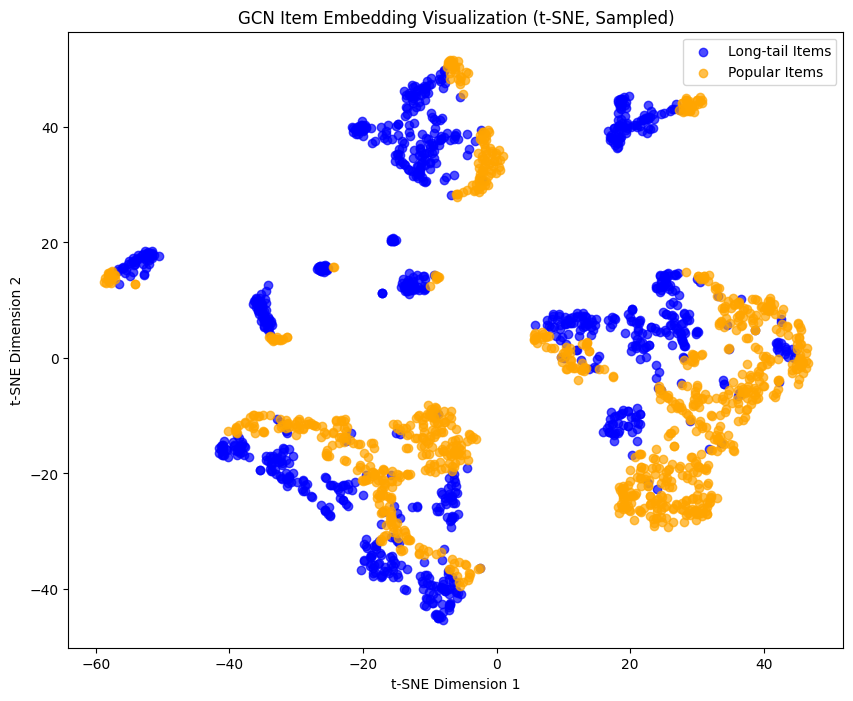

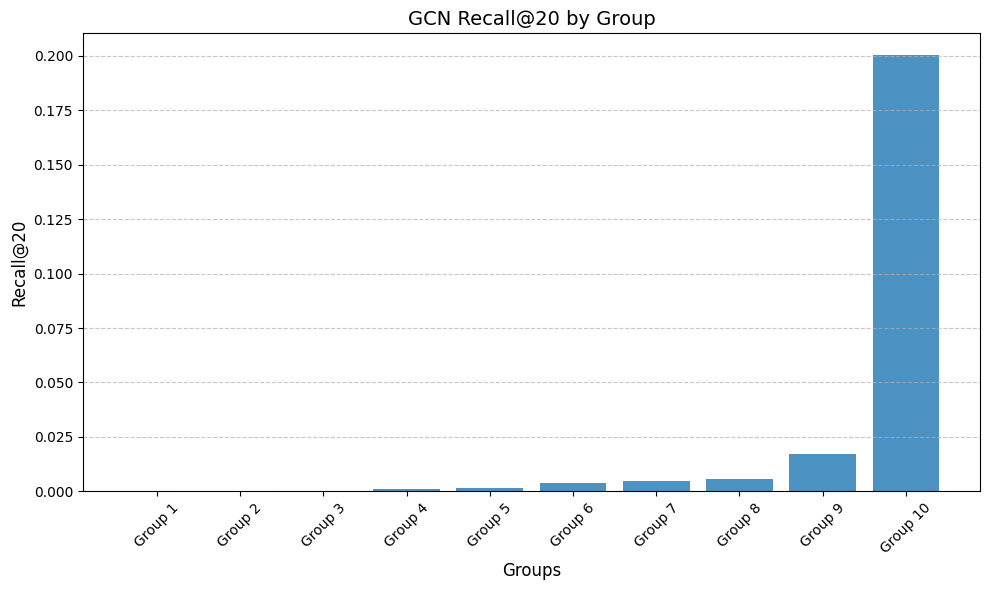

In [23]:
# recall_per_group_GCN
t_SNE_long_tail_visu(model_gcn, 'GCN')
bar_plot(10, "GCN")

## LightGCL

In [28]:
# We directly use the model in LightGCL writed by Cai et al. 

import torch
import torch.nn as nn
from utils import sparse_dropout, spmm
import torch.nn.functional as F

class LightGCL(nn.Module):
    def __init__(self, n_u, n_i, d, u_mul_s, v_mul_s, ut, vt, train_csr, adj_norm, l, temp, lambda_1, lambda_2, dropout, batch_user, device):
        super(LightGCL,self).__init__()
        self.E_u_0 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(n_u,d)))
        self.E_i_0 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(n_i,d)))

        self.train_csr = train_csr
        self.adj_norm = adj_norm
        self.l = l
        self.E_u_list = [None] * (l+1)
        self.E_i_list = [None] * (l+1)
        self.E_u_list[0] = self.E_u_0
        self.E_i_list[0] = self.E_i_0
        self.Z_u_list = [None] * (l+1)
        self.Z_i_list = [None] * (l+1)
        self.G_u_list = [None] * (l+1)
        self.G_i_list = [None] * (l+1)
        self.G_u_list[0] = self.E_u_0
        self.G_i_list[0] = self.E_i_0
        self.temp = temp
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.dropout = dropout
        self.act = nn.LeakyReLU(0.5)
        self.batch_user = batch_user

        self.E_u = None
        self.E_i = None

        self.u_mul_s = u_mul_s
        self.v_mul_s = v_mul_s
        self.ut = ut
        self.vt = vt

        self.device = device

    def forward(self, uids, iids, pos, neg, test=False):
        if test==True:  # testing phase
            preds = self.E_u[uids] @ self.E_i.T
            mask = self.train_csr[uids.cpu().numpy()].toarray()
            mask = torch.Tensor(mask).cuda(torch.device(self.device))
            preds = preds * (1-mask) - 1e8 * mask
            predictions = preds.argsort(descending=True)
            return predictions
        else:  # training phase
            for layer in range(1,self.l+1):
                # GNN propagation
                self.Z_u_list[layer] = (torch.spmm(sparse_dropout(self.adj_norm,self.dropout), self.E_i_list[layer-1]))
                self.Z_i_list[layer] = (torch.spmm(sparse_dropout(self.adj_norm,self.dropout).transpose(0,1), self.E_u_list[layer-1]))

                # svd_adj propagation
                vt_ei = self.vt @ self.E_i_list[layer-1]
                self.G_u_list[layer] = (self.u_mul_s @ vt_ei)
                ut_eu = self.ut @ self.E_u_list[layer-1]
                self.G_i_list[layer] = (self.v_mul_s @ ut_eu)

                # aggregate
                self.E_u_list[layer] = self.Z_u_list[layer]
                self.E_i_list[layer] = self.Z_i_list[layer]

            self.G_u = sum(self.G_u_list)
            self.G_i = sum(self.G_i_list)

            # aggregate across layers
            self.E_u = sum(self.E_u_list)
            self.E_i = sum(self.E_i_list)

            # cl loss
            G_u_norm = self.G_u
            E_u_norm = self.E_u
            G_i_norm = self.G_i
            E_i_norm = self.E_i
            neg_score = torch.log(torch.exp(G_u_norm[uids] @ E_u_norm.T / self.temp).sum(1) + 1e-8).mean()
            neg_score += torch.log(torch.exp(G_i_norm[iids] @ E_i_norm.T / self.temp).sum(1) + 1e-8).mean()
            pos_score = (torch.clamp((G_u_norm[uids] * E_u_norm[uids]).sum(1) / self.temp,-5.0,5.0)).mean() + (torch.clamp((G_i_norm[iids] * E_i_norm[iids]).sum(1) / self.temp,-5.0,5.0)).mean()
            loss_s = -pos_score + neg_score

            # ranking loss
            u_emb = self.E_u[uids]
            pos_emb = self.E_i[pos]
            neg_emb = self.E_i[neg]
            pos_scores = (u_emb * pos_emb).sum(-1)
            neg_scores = (u_emb * neg_emb).sum(-1)
            loss_r = -(pos_scores - neg_scores).sigmoid().log().mean()

            # reg loss
            loss_reg = 0
            for param in self.parameters():
                loss_reg += param.norm(2).square()
            loss_reg *= self.lambda_2

            # total loss
            loss = loss_r + self.lambda_1 * loss_s + loss_reg
            #print('loss',loss.item(),'loss_r',loss_r.item(),'loss_s',loss_s.item())
            return loss, loss_r, self.lambda_1 * loss_s

In [24]:
class Args:
    def __init__(self):
        self.lr = 1e-3  # Learning rate
        self.decay = 0.99  # Learning rate decay
        self.batch = 256  # Batch size
        self.inter_batch = 4096  # Intermediate batch size
        self.note = None  # Note
        self.lambda1 = 0.2  # Weight of contrastive loss
        self.epoch = 100  # Number of epochs
        self.d = 64  # Embedding size
        self.q = 5  # Rank
        self.gnn_layer = 2  # Number of GNN layers
        self.data = 'yelp'  # Dataset name
        self.dropout = 0.0  # Edge dropout rate
        self.temp = 0.2  # Temperature in contrastive loss
        self.lambda2 = 1e-7  # L2 regularization weight
        self.cuda = '0'  # GPU to use

# Instantiate the args object
args = Args()

print(f"Learning rate: {args.lr}")
print(f"Batch size: {args.batch}")
print(f"Device: cuda:{args.cuda if args.cuda else 'cpu'}")



Learning rate: 0.001
Batch size: 256
Device: cuda:0


In [25]:
import numpy as np
import torch
import pickle
from model import LightGCL
from utils import metrics, scipy_sparse_mat_to_torch_sparse_tensor
import pandas as pd
from tqdm import tqdm
import time
import torch.utils.data as data
from utils import TrnData


In [26]:
# hyperparameters
d = args.d
l = args.gnn_layer
temp = args.temp
batch_user = args.batch
epoch_no = args.epoch
max_samp = 40
lambda_1 = args.lambda1
lambda_2 = args.lambda2
dropout = args.dropout
lr = args.lr
decay = args.decay
svd_q = args.q

# load data
path = 'data/' + args.data + '/'
f = open(path+'trnMat.pkl','rb')
train = pickle.load(f)
train_csr = (train!=0).astype(np.float32)
f = open(path+'tstMat.pkl','rb')
test = pickle.load(f)
print('Data loaded.')

print('user_num:',train.shape[0],'item_num:',train.shape[1],'lambda_1:',lambda_1,'lambda_2:',lambda_2,'temp:',temp,'q:',svd_q)

epoch_user = min(train.shape[0], 30000)


Data loaded.
user_num: 29601 item_num: 24734 lambda_1: 0.2 lambda_2: 1e-07 temp: 0.2 q: 5


<ipython-input-26-da9f1010a51c>:18: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  train = pickle.load(f)
<ipython-input-26-da9f1010a51c>:21: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  test = pickle.load(f)


In [27]:
# normalizing the adj matrix
rowD = np.array(train.sum(1)).squeeze()
colD = np.array(train.sum(0)).squeeze()
for i in range(len(train.data)):
    train.data[i] = train.data[i] / pow(rowD[train.row[i]]*colD[train.col[i]], 0.5)

# construct data loader
train = train.tocoo()
train_data = TrnData(train)
train_loader = data.DataLoader(train_data, batch_size=args.inter_batch, shuffle=True, num_workers=0)

adj_norm = scipy_sparse_mat_to_torch_sparse_tensor(train)
adj_norm = adj_norm.coalesce().cuda(torch.device(device))
print('Adj matrix normalized.')

# perform svd reconstruction
adj = scipy_sparse_mat_to_torch_sparse_tensor(train).coalesce().cuda(torch.device(device))
print('Performing SVD...')
svd_u,s,svd_v = torch.svd_lowrank(adj, q=svd_q)
u_mul_s = svd_u @ (torch.diag(s))
v_mul_s = svd_v @ (torch.diag(s))
del s
print('SVD done.')

Adj matrix normalized.
Performing SVD...
SVD done.


In [29]:
# process test set
test_labels = [[] for i in range(test.shape[0])]
for i in range(len(test.data)):
    row = test.row[i]
    col = test.col[i]
    test_labels[row].append(col)
print('Test data processed.')




Test data processed.


In [30]:
# NEW MODEL
model = LightGCL(adj_norm.shape[0], adj_norm.shape[1], d, u_mul_s, v_mul_s, svd_u.T, svd_v.T, train_csr, adj_norm, l, temp, lambda_1, lambda_2, dropout, batch_user, device)
model = model.cuda(torch.device(device))
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0,lr=lr)


In [32]:
loss_list = []
loss_r_list = []
loss_s_list = []
recall_20_x = []
recall_20_y = []
ndcg_20_y = []
recall_40_y = []
ndcg_40_y = []

for epoch in range(100):
    
    epoch_loss = 0
    epoch_loss_r = 0
    epoch_loss_s = 0
    train_loader.dataset.neg_sampling()
    for i, batch in enumerate(tqdm(train_loader)):
        uids, pos, neg = batch
        uids = uids.long().cuda(torch.device(device))
        pos = pos.long().cuda(torch.device(device))
        neg = neg.long().cuda(torch.device(device))
        iids = torch.concat([pos, neg], dim=0)

        # feed
        optimizer.zero_grad()
        loss, loss_r, loss_s= model(uids, iids, pos, neg)
        loss.backward()
        optimizer.step()
        #print('batch',batch)
        epoch_loss += loss.cpu().item()
        epoch_loss_r += loss_r.cpu().item()
        epoch_loss_s += loss_s.cpu().item()

        torch.cuda.empty_cache()
        #print(i, len(train_loader), end='\r')

    batch_no = len(train_loader)
    epoch_loss = epoch_loss/batch_no
    epoch_loss_r = epoch_loss_r/batch_no
    epoch_loss_s = epoch_loss_s/batch_no
    loss_list.append(epoch_loss)
    loss_r_list.append(epoch_loss_r)
    loss_s_list.append(epoch_loss_s)
    print('Epoch:',epoch,'Loss:',epoch_loss,'Loss_r:',epoch_loss_r,'Loss_s:',epoch_loss_s)

100%|██████████| 262/262 [00:38<00:00,  6.78it/s]


Epoch: 0 Loss: 2.7881459552823133 Loss_r: 0.3599179550891614 Loss_s: 2.4251203318588606


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 1 Loss: 2.6223718865227155 Loss_r: 0.377995764708701 Loss_s: 2.240576875118809


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 2 Loss: 2.59828342463224 Loss_r: 0.37570124329956434 Loss_s: 2.2187223170549815


100%|██████████| 262/262 [00:38<00:00,  6.78it/s]


Epoch: 3 Loss: 2.5862756321448406 Loss_r: 0.3706943828413505 Loss_s: 2.21172542153424


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 4 Loss: 2.57771564075965 Loss_r: 0.36587716741416293 Loss_s: 2.207999039242286


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 5 Loss: 2.5713744245412697 Loss_r: 0.361819401042152 Loss_s: 2.205732674089097


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 6 Loss: 2.5664945404038173 Loss_r: 0.3585147870178441 Loss_s: 2.2041741500374017


100%|██████████| 262/262 [00:38<00:00,  6.83it/s]


Epoch: 7 Loss: 2.5626103532223303 Loss_r: 0.35569292682272785 Loss_s: 2.203126485111149


100%|██████████| 262/262 [00:38<00:00,  6.74it/s]


Epoch: 8 Loss: 2.5591732190765497 Loss_r: 0.35322854662214526 Loss_s: 2.2021663580231996


100%|██████████| 262/262 [00:38<00:00,  6.82it/s]


Epoch: 9 Loss: 2.5566979100685994 Loss_r: 0.35147511902201267 Loss_s: 2.2014550452923958


100%|██████████| 262/262 [00:38<00:00,  6.77it/s]


Epoch: 10 Loss: 2.5545041761325518 Loss_r: 0.34987768439846184 Loss_s: 2.200867969571179


100%|██████████| 262/262 [00:37<00:00,  6.93it/s]


Epoch: 11 Loss: 2.552548118220031 Loss_r: 0.3484359549657079 Loss_s: 2.200361732308191


100%|██████████| 262/262 [00:38<00:00,  6.89it/s]


Epoch: 12 Loss: 2.5510192144918076 Loss_r: 0.3472523067061228 Loss_s: 2.200022862157749


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 13 Loss: 2.549242879598195 Loss_r: 0.3458408990889105 Loss_s: 2.199664281524775


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 14 Loss: 2.5482546018280146 Loss_r: 0.34515253562508647 Loss_s: 2.1993680837500187


100%|██████████| 262/262 [00:38<00:00,  6.81it/s]


Epoch: 15 Loss: 2.5471191542749185 Loss_r: 0.34430896018752616 Loss_s: 2.199081275299305


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 16 Loss: 2.5461649958413974 Loss_r: 0.3435940270432989 Loss_s: 2.1988455985338633


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 17 Loss: 2.5452986682644325 Loss_r: 0.3428420020651271 Loss_s: 2.198734187897835


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 18 Loss: 2.544861755298294 Loss_r: 0.3425571497615057 Loss_s: 2.1985843673007177


100%|██████████| 262/262 [00:38<00:00,  6.78it/s]


Epoch: 19 Loss: 2.543934524514293 Loss_r: 0.3418034772381528 Loss_s: 2.1984131845809123


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 20 Loss: 2.5432339242396464 Loss_r: 0.34125481307051564 Loss_s: 2.1982637543714683


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 21 Loss: 2.5428448305785203 Loss_r: 0.340976441520771 Loss_s: 2.198154860780439


100%|██████████| 262/262 [00:38<00:00,  6.81it/s]


Epoch: 22 Loss: 2.5423541023531033 Loss_r: 0.34070889663150294 Loss_s: 2.1979336993384906


100%|██████████| 262/262 [00:38<00:00,  6.82it/s]


Epoch: 23 Loss: 2.541979100867992 Loss_r: 0.3403762729113339 Loss_s: 2.1978922163257164


100%|██████████| 262/262 [00:38<00:00,  6.81it/s]


Epoch: 24 Loss: 2.541593818264153 Loss_r: 0.34002291086975855 Loss_s: 2.1978617460673093


100%|██████████| 262/262 [00:38<00:00,  6.74it/s]


Epoch: 25 Loss: 2.5413201974548456 Loss_r: 0.3398537081844024 Loss_s: 2.1977580731151667


100%|██████████| 262/262 [00:38<00:00,  6.86it/s]


Epoch: 26 Loss: 2.5410940428726545 Loss_r: 0.3397254139639949 Loss_s: 2.1976613224917694


100%|██████████| 262/262 [00:38<00:00,  6.73it/s]


Epoch: 27 Loss: 2.540563465984723 Loss_r: 0.33915231393948764 Loss_s: 2.197703697299229


100%|██████████| 262/262 [00:38<00:00,  6.85it/s]


Epoch: 28 Loss: 2.54034315265772 Loss_r: 0.3390258648468338 Loss_s: 2.1976113592395348


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 29 Loss: 2.540045318712715 Loss_r: 0.33883858637045355 Loss_s: 2.1975015583839124


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 30 Loss: 2.539780287342217 Loss_r: 0.33861582322430067 Loss_s: 2.197459756873036


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 31 Loss: 2.539701885849465 Loss_r: 0.3386652683483735 Loss_s: 2.1973325478211616


100%|██████████| 262/262 [00:38<00:00,  6.82it/s]


Epoch: 32 Loss: 2.5396285648564345 Loss_r: 0.33852099166571636 Loss_s: 2.1974040033253095


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 33 Loss: 2.53930340559428 Loss_r: 0.3382706927661677 Loss_s: 2.1973302136850723


100%|██████████| 262/262 [00:38<00:00,  6.85it/s]


Epoch: 34 Loss: 2.5391690703748746 Loss_r: 0.33820161246161423 Loss_s: 2.1972647204653906


100%|██████████| 262/262 [00:38<00:00,  6.89it/s]


Epoch: 35 Loss: 2.539344136041539 Loss_r: 0.3384316112021454 Loss_s: 2.1972102436400553


100%|██████████| 262/262 [00:37<00:00,  6.90it/s]


Epoch: 36 Loss: 2.5387438735889116 Loss_r: 0.3378350607311453 Loss_s: 2.1972067447109076


100%|██████████| 262/262 [00:38<00:00,  6.89it/s]


Epoch: 37 Loss: 2.5387793897672464 Loss_r: 0.3379554463024358 Loss_s: 2.197122339073938


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 38 Loss: 2.538753319332618 Loss_r: 0.33784179446351437 Loss_s: 2.1972100989509173


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 39 Loss: 2.538538489632934 Loss_r: 0.3376218231807228 Loss_s: 2.197214825462749


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 40 Loss: 2.5383290398211877 Loss_r: 0.3374650148490003 Loss_s: 2.197162348805493


100%|██████████| 262/262 [00:38<00:00,  6.84it/s]


Epoch: 41 Loss: 2.538185586456124 Loss_r: 0.33738307233985143 Loss_s: 2.1971019533754306


100%|██████████| 262/262 [00:38<00:00,  6.77it/s]


Epoch: 42 Loss: 2.538287291089997 Loss_r: 0.3375211133984209 Loss_s: 2.197066453576998


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 43 Loss: 2.537980004121329 Loss_r: 0.3372198644712681 Loss_s: 2.1970596732074066


100%|██████████| 262/262 [00:38<00:00,  6.76it/s]


Epoch: 44 Loss: 2.5380147431642954 Loss_r: 0.3372947181226643 Loss_s: 2.1970210148177984


100%|██████████| 262/262 [00:38<00:00,  6.82it/s]


Epoch: 45 Loss: 2.537792269510167 Loss_r: 0.3370923256601086 Loss_s: 2.197000093132485


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 46 Loss: 2.5378150257445475 Loss_r: 0.3371689507296977 Loss_s: 2.196946924879351


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 47 Loss: 2.5378369993835914 Loss_r: 0.3372098279135828 Loss_s: 2.1969274246055663


100%|██████████| 262/262 [00:38<00:00,  6.78it/s]


Epoch: 48 Loss: 2.5377509948861507 Loss_r: 0.3371650241030992 Loss_s: 2.1968872146752045


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 49 Loss: 2.5375782588056026 Loss_r: 0.3369520594373004 Loss_s: 2.196927848663039


100%|██████████| 262/262 [00:38<00:00,  6.81it/s]


Epoch: 50 Loss: 2.537604239150768 Loss_r: 0.336887723161974 Loss_s: 2.197017978165896


100%|██████████| 262/262 [00:38<00:00,  6.85it/s]


Epoch: 51 Loss: 2.5374909784957653 Loss_r: 0.33689852741383414 Loss_s: 2.1968936710867264


100%|██████████| 262/262 [00:38<00:00,  6.81it/s]


Epoch: 52 Loss: 2.5373192388592787 Loss_r: 0.33670558524495775 Loss_s: 2.196915063239236


100%|██████████| 262/262 [00:38<00:00,  6.80it/s]


Epoch: 53 Loss: 2.5371805711556936 Loss_r: 0.33656480260022725 Loss_s: 2.1969170834271963


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 54 Loss: 2.537228404110625 Loss_r: 0.33658331291366167 Loss_s: 2.1969467146706037


100%|██████████| 262/262 [00:38<00:00,  6.81it/s]


Epoch: 55 Loss: 2.5373645820690474 Loss_r: 0.33685317737910586 Loss_s: 2.196811998163471


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 56 Loss: 2.537264914003037 Loss_r: 0.3367782795929727 Loss_s: 2.196788980760647


100%|██████████| 262/262 [00:38<00:00,  6.79it/s]


Epoch: 57 Loss: 2.5373464395071714 Loss_r: 0.3367477270938058 Loss_s: 2.1969008655038498


100%|██████████| 262/262 [00:38<00:00,  6.86it/s]


Epoch: 58 Loss: 2.5370642374490053 Loss_r: 0.3365452969802245 Loss_s: 2.196820767781207


100%|██████████| 262/262 [00:38<00:00,  6.75it/s]


Epoch: 59 Loss: 2.5370321373903115 Loss_r: 0.3365675588600508 Loss_s: 2.1967663764953613


100%|██████████| 262/262 [00:38<00:00,  6.83it/s]


Epoch: 60 Loss: 2.537060483721376 Loss_r: 0.3365786627276253 Loss_s: 2.1967836736722757


100%|██████████| 262/262 [00:38<00:00,  6.73it/s]


Epoch: 61 Loss: 2.536950249708336 Loss_r: 0.33651239021133833 Loss_s: 2.1967395325653425


100%|██████████| 262/262 [00:38<00:00,  6.75it/s]


Epoch: 62 Loss: 2.5368719756148246 Loss_r: 0.3364638545130955 Loss_s: 2.196710342669305


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 63 Loss: 2.536827314900988 Loss_r: 0.3363853074212111 Loss_s: 2.1967443810164475


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 64 Loss: 2.53673231783714 Loss_r: 0.3363091639662517 Loss_s: 2.1967256587880257


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 65 Loss: 2.536779576585493 Loss_r: 0.33634091344953493 Loss_s: 2.1967410595362424


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 66 Loss: 2.536699951150035 Loss_r: 0.3362495772938692 Loss_s: 2.196753015954986


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 67 Loss: 2.5364696142327694 Loss_r: 0.3360045892364196 Loss_s: 2.196767920756158


100%|██████████| 262/262 [00:38<00:00,  6.75it/s]


Epoch: 68 Loss: 2.5366654905654094 Loss_r: 0.33626598824981513 Loss_s: 2.1967020153089334


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]


Epoch: 69 Loss: 2.5364759650849202 Loss_r: 0.33598496599961786 Loss_s: 2.196793517083612


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 70 Loss: 2.5362931990441475 Loss_r: 0.33584171647333916 Loss_s: 2.1967538813598284


100%|██████████| 262/262 [00:39<00:00,  6.68it/s]


Epoch: 71 Loss: 2.536646399789184 Loss_r: 0.33623202986844625 Loss_s: 2.196716499692611


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]


Epoch: 72 Loss: 2.536670882283276 Loss_r: 0.33626403619769873 Loss_s: 2.196708897597917


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]


Epoch: 73 Loss: 2.536401323689759 Loss_r: 0.3360490828525019 Loss_s: 2.196654176894035


100%|██████████| 262/262 [00:39<00:00,  6.70it/s]


Epoch: 74 Loss: 2.5363722994127347 Loss_r: 0.33601463250531494 Loss_s: 2.196660901753957


100%|██████████| 262/262 [00:38<00:00,  6.72it/s]


Epoch: 75 Loss: 2.5364727528040647 Loss_r: 0.3361315837570729 Loss_s: 2.196644184243588


100%|██████████| 262/262 [00:39<00:00,  6.66it/s]


Epoch: 76 Loss: 2.536593984101565 Loss_r: 0.336294598706806 Loss_s: 2.196602853199908


100%|██████████| 262/262 [00:38<00:00,  6.74it/s]


Epoch: 77 Loss: 2.53637489926724 Loss_r: 0.3360275389583966 Loss_s: 2.196650634285148


100%|██████████| 262/262 [00:39<00:00,  6.67it/s]


Epoch: 78 Loss: 2.5364693066546025 Loss_r: 0.3360266453437223 Loss_s: 2.196745797878003


100%|██████████| 262/262 [00:38<00:00,  6.75it/s]


Epoch: 79 Loss: 2.5365557843492232 Loss_r: 0.3362409384878537 Loss_s: 2.1966186852855536


100%|██████████| 262/262 [00:39<00:00,  6.70it/s]


Epoch: 80 Loss: 2.5363138986907843 Loss_r: 0.33597781435223933 Loss_s: 2.1966391419636384


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 81 Loss: 2.5362984124030774 Loss_r: 0.3358928481586107 Loss_s: 2.196708715599002


100%|██████████| 262/262 [00:39<00:00,  6.70it/s]


Epoch: 82 Loss: 2.5362475437062386 Loss_r: 0.33582464133510154 Loss_s: 2.1967265596826566


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]


Epoch: 83 Loss: 2.536147751880966 Loss_r: 0.33582158591456085 Loss_s: 2.1966289409244335


100%|██████████| 262/262 [00:39<00:00,  6.68it/s]


Epoch: 84 Loss: 2.536270028762235 Loss_r: 0.335876903119888 Loss_s: 2.1966957572762293


100%|██████████| 262/262 [00:38<00:00,  6.72it/s]


Epoch: 85 Loss: 2.5361466007378266 Loss_r: 0.33575355699499143 Loss_s: 2.196695966574982


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]


Epoch: 86 Loss: 2.5362317361904463 Loss_r: 0.33595185470945055 Loss_s: 2.1965827568796756


100%|██████████| 262/262 [00:39<00:00,  6.70it/s]


Epoch: 87 Loss: 2.536257636456089 Loss_r: 0.3360101784231099 Loss_s: 2.196550838819897


100%|██████████| 262/262 [00:39<00:00,  6.70it/s]


Epoch: 88 Loss: 2.53599660724174 Loss_r: 0.33568227950853247 Loss_s: 2.1966175268624575


100%|██████████| 262/262 [00:39<00:00,  6.70it/s]


Epoch: 89 Loss: 2.536268469941525 Loss_r: 0.33587129778079405 Loss_s: 2.1967003445588906


100%|██████████| 262/262 [00:39<00:00,  6.71it/s]


Epoch: 90 Loss: 2.536246092264889 Loss_r: 0.33595757345661864 Loss_s: 2.196591392728209


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]


Epoch: 91 Loss: 2.5360374623582564 Loss_r: 0.3356932045621726 Loss_s: 2.196647456584086


100%|██████████| 262/262 [00:38<00:00,  6.74it/s]


Epoch: 92 Loss: 2.5359684865893297 Loss_r: 0.335694904090794 Loss_s: 2.196577114003305


100%|██████████| 262/262 [00:39<00:00,  6.66it/s]


Epoch: 93 Loss: 2.5359375549636725 Loss_r: 0.335651307956863 Loss_s: 2.196589621878762


100%|██████████| 262/262 [00:38<00:00,  6.73it/s]


Epoch: 94 Loss: 2.5361054526030564 Loss_r: 0.33585703930327 Loss_s: 2.19655167055494


100%|██████████| 262/262 [00:39<00:00,  6.65it/s]


Epoch: 95 Loss: 2.5362087533674167 Loss_r: 0.3359490687610539 Loss_s: 2.1965634358748223


100%|██████████| 262/262 [00:38<00:00,  6.73it/s]


Epoch: 96 Loss: 2.535981488591842 Loss_r: 0.33571921391341525 Loss_s: 2.196565574362078


100%|██████████| 262/262 [00:39<00:00,  6.65it/s]


Epoch: 97 Loss: 2.5358978719201706 Loss_r: 0.33558689581073875 Loss_s: 2.196614623979758


100%|██████████| 262/262 [00:38<00:00,  6.74it/s]


Epoch: 98 Loss: 2.536002224638262 Loss_r: 0.3357488847415866 Loss_s: 2.1965569093937183


100%|██████████| 262/262 [00:39<00:00,  6.69it/s]

Epoch: 99 Loss: 2.535973862837289 Loss_r: 0.33571207102473455 Loss_s: 2.1965650784150337


In [34]:
import numpy as np
import torch

def long_tail_evaluate_gcl(model, train_matrix, test_matrix, k=20, n_groups=10, device='cpu'):
    
    item_counts = np.array(train_matrix.sum(axis=0)).flatten()  # shape (n_items,)
    n_items = len(item_counts)

    sorted_items = np.argsort(item_counts)  
    group_size = n_items // n_groups
    item_groups = []
    for g in range(n_groups):
        start = g * group_size
        end = (g + 1) * group_size if g < n_groups - 1 else n_items
        item_groups.append(set(sorted_items[start:end]))

    model.eval()

    user_emb = model.E_u.to(device)  # (n_users, d)
    item_emb = model.E_i.to(device)  # (n_items, d)

    scores = torch.matmul(user_emb, item_emb.t())  # (n_users, n_items)

    train_coo = train_matrix.tocoo()
    for u, i in zip(train_coo.row, train_coo.col):
        scores[u, i] = -1e9  

    _, topk_indices = torch.topk(scores, k=k, dim=1)  # (n_users, k)

    test_coo = test_matrix.tocoo()
    test_dict = {}
    for u, i in zip(test_coo.row, test_coo.col):
        if u not in test_dict:
            test_dict[u] = []
        test_dict[u].append(i)

    recall_per_group = [0.0] * n_groups
    group_counts = [0] * n_groups 

    for user in test_dict:
        true_items = set(test_dict[user]) 
        pred_items = topk_indices[user].cpu().numpy().tolist()  
        for g in range(n_groups):
            group_items = item_groups[g]
            true_in_group = true_items & group_items
            if len(true_in_group) == 0:
                continue

            pred_in_group = set(pred_items) & group_items
            hit = len(pred_in_group & true_in_group)

            recall_per_group[g] += hit / len(true_in_group)
            group_counts[g] += 1

    for g in range(n_groups):
        if group_counts[g] > 0:
            recall_per_group[g] /= group_counts[g]

    return recall_per_group


In [35]:
recall_per_group_gcl = long_tail_evaluate_gcl(model, train_matrix, test_matrix, k=20, n_groups=10, device='cpu')
for g, recall in enumerate(recall_per_group_gcl):
    print(f"Group {g+1}: Recall@20 = {recall:.4f}")

Group 1: Recall@20 = 0.0034
Group 2: Recall@20 = 0.0055
Group 3: Recall@20 = 0.0080
Group 4: Recall@20 = 0.0156
Group 5: Recall@20 = 0.0179
Group 6: Recall@20 = 0.0272
Group 7: Recall@20 = 0.0398
Group 8: Recall@20 = 0.0587
Group 9: Recall@20 = 0.0948
Group 10: Recall@20 = 0.2084


In [36]:
import random
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def t_SNE_long_tail_visu_gcl(lightgcl_model, train_matrix, device='cpu'):
    

    lightgcl_model.eval()
    

    item_emb = lightgcl_model.E_i
    item_embeddings = item_emb.detach().cpu().numpy()  

    item_interaction_counts = np.array(train_matrix.sum(axis=0)).flatten()

    threshold = np.percentile(item_interaction_counts, 90) 
    long_tail_items = np.where(item_interaction_counts <= threshold)[0]
    popular_items = np.where(item_interaction_counts > threshold)[0]

    num_samples = 1000
    sampled_long_tail_items = random.sample(list(long_tail_items), 
                                           min(len(long_tail_items), num_samples))
    sampled_popular_items = random.sample(list(popular_items), 
                                         min(len(popular_items), num_samples))
    sampled_items = np.array(sampled_long_tail_items + sampled_popular_items)

    sampled_embeddings = item_embeddings[sampled_items]

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    sampled_2d_embeddings = tsne.fit_transform(sampled_embeddings)

    plt.figure(figsize=(10, 8))

    plt.scatter(
        sampled_2d_embeddings[:len(sampled_long_tail_items), 0],
        sampled_2d_embeddings[:len(sampled_long_tail_items), 1],
        label='Long-tail Items', alpha=0.7, c='blue'
    )
    plt.scatter(
        sampled_2d_embeddings[len(sampled_long_tail_items):, 0],
        sampled_2d_embeddings[len(sampled_long_tail_items):, 1],
        label='Popular Items', alpha=0.7, c='orange'
    )

    plt.title('LightGCL Item Embedding Visualization (t-SNE, Sampled)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()


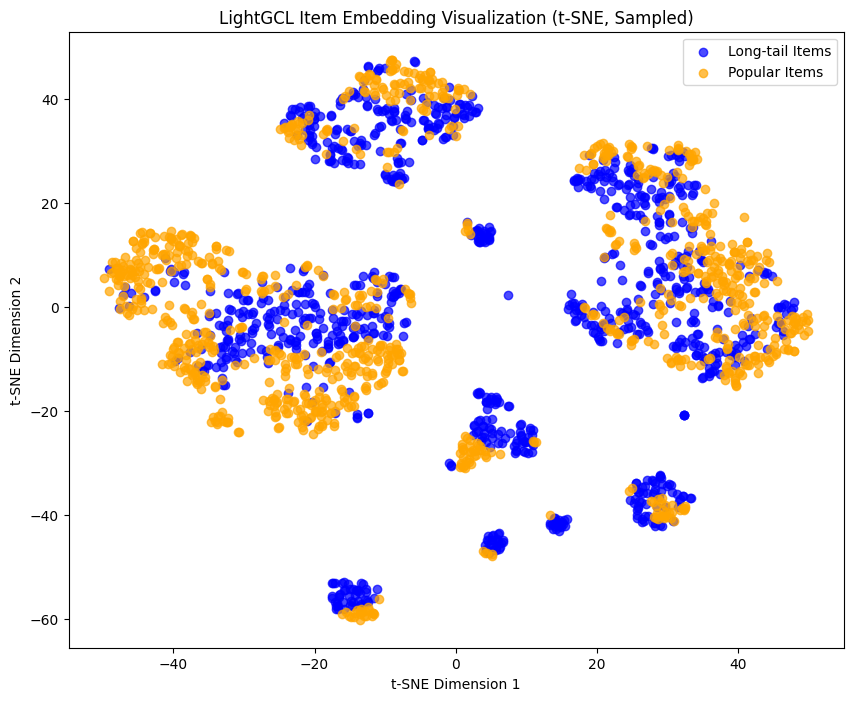

In [42]:
t_SNE_long_tail_visu_gcl(model, train_matrix, device = device)

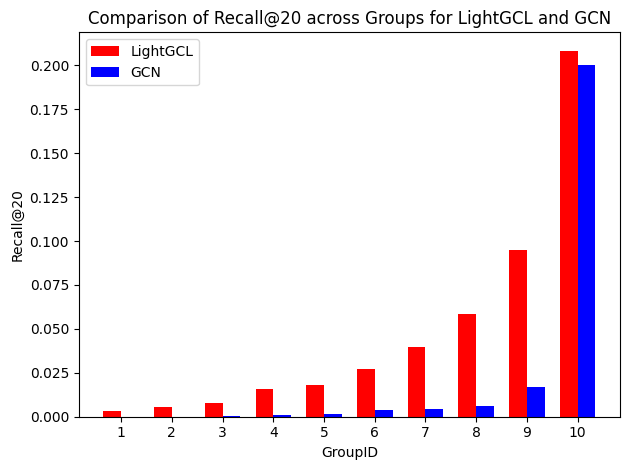

In [49]:
import matplotlib.pyplot as plt
import numpy as np

group_ids = np.arange(1, 11)  # GroupID: 1 - 10
lightgcl_recall = recall_per_group_gcl
gcn_recall = recall_per_group

bar_width = 0.35
index = np.arange(len(group_ids))

plt.bar(index - bar_width/2, lightgcl_recall, bar_width, label='LightGCL', color='red')
plt.bar(index + bar_width/2, gcn_recall, bar_width, label='GCN', color='blue')
plt.xlabel('GroupID')
plt.ylabel('Recall@20')
plt.title('Comparison of Recall@20 across Groups for LightGCL and GCN')
plt.xticks(index, group_ids)
plt.legend()

# Show
plt.tight_layout()
plt.show()
